In [59]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


In [53]:
## Import the Data and Predictions
deaths_true = pd.read_csv("../../data/usafacts/deaths.csv")

## Getting the columns we want
deaths_true = deaths_true[["State", "4/2/2020"]].groupby("State")\
    .agg( {'4/2/2020':  'sum'}).reset_index().rename(columns={"State": "state", "4/2/2020": "deaths"})


# predictions
deaths_pred = pd.read_csv("./yugroup/03_31.csv")
deaths_pred = deaths_pred[deaths_pred["state"] != "US"]

# IHME predictions
deaths_ihme = pd.read_csv("./ihme/2020-03-31.csv")
filtered_cols = ["Other Counties, WA", "US","King and Snohomish Counties (excluding Life Care Center), WA",
                                               "Life Care Center, Kirkland, WA"]
deaths_ihme = \
    deaths_ihme[~deaths_ihme["location"].isin(filtered_cols)]
deaths_ihme["state"] = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT",  "DE", "DC","FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"] 
deaths_ihme = deaths_ihme[["state", "3_day_mean"]] # "3_day_lower", "3_day_upper"]]

In [55]:
### PROCESS THE MODEL WE WANT HERE
deaths_pred = deaths_pred[["state", "predicted_deaths_ensemble_3"]]

In [56]:
# Dataframe of Truth and Lies (Predictions)
df = deaths_true.merge(deaths_pred, how="left", on="state")\
    .merge(deaths_ihme, how="left", on="state")

In [58]:
## Let's Compute some losses

# L1 Loss
df = df.assign(l1_ours=lambda x: np.abs(x.deaths - x.predicted_deaths_ensemble_3))
df = df.assign(l1_theirs = lambda x: np.abs(x.deaths - x["3_day_mean"]))

# L2 Loss
df = df.assign(l2_ours=lambda x: (x.deaths - x.predicted_deaths_ensemble_3)**2)
df = df.assign(l2_theirs = lambda x: (x.deaths - x["3_day_mean"])**2)

# Log L1 Loss
df = df.assign(l1_log_ours=lambda x: np.log(np.abs(x.deaths - x.predicted_deaths_ensemble_3) + 1))
df = df.assign(l1_log_theirs = lambda x: np.log(np.abs(x.deaths - x["3_day_mean"]) + 1))

# Log L2 Loss
df = df.assign(l2_log_ours=lambda x: np.log((x.deaths - x.predicted_deaths_ensemble_3)**2 + 1))
df = df.assign(l2_log_theirs = lambda x: np.log((x.deaths - x["3_day_mean"])**2 + 1))


## Compute the Results
res_cols = ["l1_ours", "l1_theirs", 
           "l2_ours", "l2_theirs",
            "l1_log_ours", "l1_log_theirs",
           "l2_log_ours", "l2_log_theirs"]
res = df[res_cols]

res.agg("sum")

l1_ours          1.423300e+23
l1_theirs        4.706148e+03
l2_ours          2.025783e+46
l2_theirs        3.966430e+06
l1_log_ours      2.522248e+02
l1_log_theirs    1.597854e+02
l2_log_ours      5.008009e+02
l2_log_theirs    3.109970e+02
dtype: float64

In [48]:
df.head()

,state,deaths,predicted_deaths_ensemble_1,3_day_mean,l1_theirs,l2_theirs,l1_ours,l2_ours,l1_log_ours,l1_log_theirs,l2_log_ours,l2_log_theirs
0,AK,3.0,3.132910,2.104,0.896,0.802816,0.132910,0.017665,0.124789,0.639746,0.017511,0.589350
1,AL,17.0,41.463539,24.847,7.847,61.575409,24.463539,598.464733,3.237248,2.180078,6.396037,4.136372
2,AR,12.0,37.887254,2.805,9.195,84.548025,25.887254,670.149932,3.291652,2.321897,6.508993,4.449078
3,AZ,32.0,23.750822,6.794,25.206,635.342436,8.249178,68.048944,2.224535,3.265988,4.234816,6.455737
4,CA,243.0,201.901209,39.049,203.951,41596.010401,41.098791,1689.110597,3.740019,5.322771,7.432549,10.635784


/home/robbie/anaconda3/envs/whynot/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


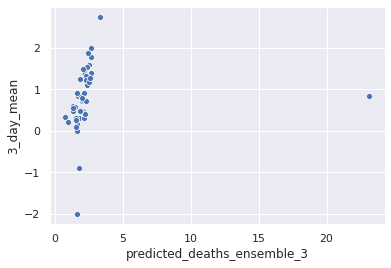

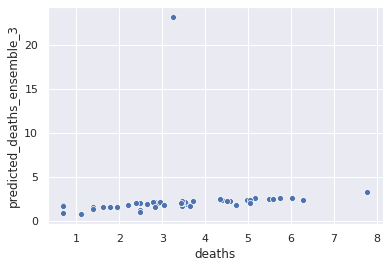

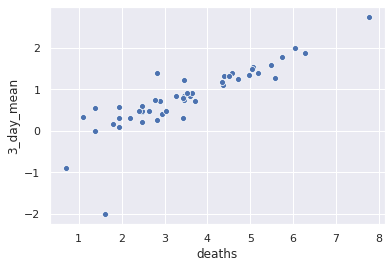

In [76]:
## Scatter Plots
# Log Transform since idk seaborn
plt_df = np.log(df[["deaths"]])
plt_df["predicted_deaths_ensemble_3"] = np.log10(df["predicted_deaths_ensemble_3"])
plt_df["3_day_mean"] = np.log10(df["3_day_mean"])


# Our Preds -- Their Preds
f, ax = plt.subplots()
sns.scatterplot(x = "predicted_deaths_ensemble_3", y="3_day_mean", data=plt_df)

# Our Preds -- Real Data
f, ax = plt.subplots()
sns.scatterplot(x = "deaths", y="predicted_deaths_ensemble_3", data=plt_df)

# Their Preds Real Data
f, ax = plt.subplots()
sns.scatterplot(x = "deaths", y="3_day_mean", data=plt_df)